In [1]:
%config IPCompleter.greedy=True

In [24]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
## nltk
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
## sklearn
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
## classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
## pipeline
from sklearn.pipeline import Pipeline



In [5]:
train = pd.read_csv('./Data/emails.train.csv')
text = train['text']

# Cleaning Data

In [6]:
re_tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b') # tokenize words that are not numbers
mystopwords = set(stopwords.words('english')) # stop words remover
extras = set(['_', 'subject']) # remove subject and _
mystopwords.update(extras)
#ps = PorterStemmer() # stemming words
#stemmer = SnowballStemmer("english") # stemming words
lemmatizer = WordNetLemmatizer() # lemmatizing words

In [7]:
## First, lemmatize and create list of words
def lemma(df):
    # lemmatize 
    for i, line in enumerate(df['text']): 
        newline = [] 
        words = line.split() 
        for word in words: 
            word = lemmatizer.lemmatize(word) 
            newline.append(word) 
        new = ' '.join(newline)  
        df.loc[i, 'text'] = new # replace line at the index position with the new line that is the lemmatized words

In [8]:
## data
train = pd.read_csv('./Data/emails.train.csv')
test  = pd.read_csv('./Data/emails.test.csv')

lemma(train)
lemma(test)

# for i in 10:

# Get labels splitted set
subtrain_X, subval_X = train_test_split(train, test_size = 0.25, )

Y_train = train['spam']
Y_test = test['spam']

## tf-idf vectorizer

In [12]:
vectorizer = TfidfVectorizer(stop_words=mystopwords, tokenizer=re_tokenizer.tokenize, max_features = 1000)
vectorizer.fit(train['text'])

X_train = vectorizer.transform(train['text']).todense() ## features
X_test = vectorizer.transform(test['text']).todense() ## features

# KNN model classifier

In [22]:
random_k = list(range(1,50))

# only odd numbers
neighbor = filter(lambda x: x % 2 != 0, random_k)

cross_scores = []

# 10 fold crossvalidation using training set, to find optimal k-value for classifier
for k in neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cross_scores.append(scores.mean())

# misclassification error
MSE = [1 - x for x in cross_scores]
optimal_k = neighbor[MSE.index(min(MSE))]
print "The optimal number of neighbors is %d" % optimal_k

The optimal number of neighbors is 35


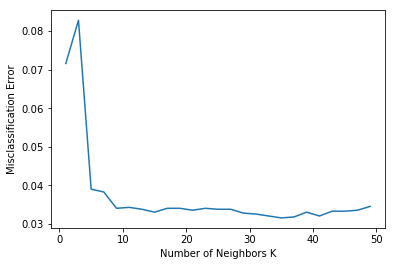

In [25]:
# plot with MSE vs k
plt.plot(neighbor, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [31]:
# with use of optimal_k
knn = KNeighborsClassifier(n_neighbors= optimal_k)

# model fitting
knn.fit(X_train, Y_train)

# predict
Y_pred = knn.predict(X_test)

# accuracy evaluation
print accuracy_score(Y_test, Y_pred)

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('knn.csv', index=False)

0.959578207381


# Random Forest Model Classifier

In [34]:
rf_class = RandomForestClassifier() 
 
# Use a grid search to find optimal parameters
param_grid = { 
           "n_estimators" : [8, 16, 32, 40, 48, 56],
           "max_depth" : [1, 5, 10, 15, 20, 25],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
CV_rf_class = GridSearchCV(estimator=rf_class, param_grid=param_grid, n_jobs=-1)
CV_rf_class.fit(X_train, Y_train)
print CV_rf_class.best_params_


{'n_estimators': 40, 'max_depth': 25, 'min_samples_leaf': 2}


In [35]:
print CV_rf_class.best_score_

0.970902760507


In [36]:
est = grid_search.best_estimator_
Y_pred = est.predict(X_test)

pd.DataFrame({
    'id': test.id,
    'spam': Y_pred
}).to_csv('rforest.csv', index=False)